# Peering DB graph and dataset creation

API peeringDB explaining all the metadata : https://www.peeringdb.com/apidocs/#operation/list%20net 

---------
- In this notebook, we create the graph and dataset from PeeringDB metadata.
Then we display some meaningful features to extract the most relevant metadata from the 34 available.
---------

This notebook describes part of the PeeringDB dataset.  
It consists in IXP metadata (table `ix`), ASes metadata (table `net`), a directed Graph (`DiGraph`) and a table containing the graph's nodes metadata (table `nodes`).

In [21]:
import numpy as np
import pandas as pd
import networkx as nx
import pickle
import os
import matplotlib.pyplot as plt
from sklearn import preprocessing
from numpy import arange

## Graph creation

### Loading preprocessed data
Notes on the preprocessing

* All entries are uniquely defined with an index.
 * ASes: the index is the AS number (asn)
 * IXPs: a negative number that I attributed
* The graph is first built from infos present in `netixlan_set` of the API. This makes a bipartite graph (AS-IXP) with links weighted by the router port size (`speed` in the API)
* We want to derive a directed graph: we rely on ASes `info_ratio` attribute, that can take the values `Not Disclosed`, `Heavy In(out)bound`, `Mostly In(out)bound`, `Balanced`.
 * Inbound: a link is created with a weight=`speed` from IXP to AS. Another link of weight $(1-\beta)$*`speed` is created in the other direction
 * Outbound: a link is created with a weight=`speed` from AS to IXP. Another link of weight $(1-\beta)$*`speed` is created in the other direction
 * `Balanced` or `Not Disclosed`: A link in both direction with a weight=`speed`
 * Heavy categories: $\beta=\beta_H=0.95$, Mostly categories: $\beta=\beta_M=0.75$

In [22]:
path = "./"
prefix = "peeringdb_2_dump_"
date = "2021_03_01"

pickle_in = open(path+"nodes/"+prefix+date+".pickle", "rb")
nodes = pickle.load(pickle_in)
pickle_in.close()
nodes = nodes.loc[nodes["port_capacity"]>0] ##port capacity = sum of all ports
print("nodes table summary")
display(nodes.info())

pickle_in = open(path+"ix/"+prefix+date+".pickle", "rb")
ix = pickle.load(pickle_in)
pickle_in.close()
ix = ix.loc[ix["port_capacity"]>0]
print("ix table summary")
display(ix.info())

pickle_in = open(path+"net/"+prefix+date+".pickle", "rb")
net = pickle.load(pickle_in)
pickle_in.close()
net = net.loc[net["port_capacity"]>0]
print("net table summary")
display(net.info())

BETA_H = 0.95
BETA_M = 0.75

edgelist = open(path+"graph/"+format(BETA_H, '.4f')+"_"+format(BETA_M, '.4f')+"_"+prefix+date+".txt", "r")
DiGraph = nx.parse_edgelist(edgelist, nodetype = int, data=(('weight',float),), create_using = nx.DiGraph, delimiter=",")


assert(len(nodes) == len(ix) + len(net))
assert(len(nodes) == len(DiGraph))

print("Total number of nodes:", len(nodes))
print("Total number of IXP:", len(ix))
print("Total number of ASes: ", len(net))
print("Total number of edges: ", len(DiGraph.edges()))

nodes table summary
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12282 entries, 20940 to -893
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           12282 non-null  object 
 1   type           12282 non-null  object 
 2   prev_id        12282 non-null  int64  
 3   AStype         11472 non-null  object 
 4   region         12282 non-null  object 
 5   asn            12282 non-null  int64  
 6   port_capacity  12282 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 767.6+ KB


None

ix table summary
<class 'pandas.core.frame.DataFrame'>
Int64Index: 810 entries, -1 to -893
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   proto_ipv6        810 non-null    bool  
 1   status            810 non-null    object
 2   url_stats         810 non-null    object
 3   id                810 non-null    int64 
 4   tech_email        810 non-null    object
 5   city              810 non-null    object
 6   policy_email      810 non-null    object
 7   tech_phone        810 non-null    object
 8   media             810 non-null    object
 9   proto_multicast   810 non-null    bool  
 10  ixf_last_import   127 non-null    object
 11  website           810 non-null    object
 12  updated           810 non-null    object
 13  net_count         810 non-null    int64 
 14  policy_phone      810 non-null    object
 15  proto_unicast     810 non-null    bool  
 16  region_continent  810 non-null    object
 1

None

net table summary
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11472 entries, 20940 to 61437
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   status                        11472 non-null  object 
 1   looking_glass                 11472 non-null  object 
 2   route_server                  11472 non-null  object 
 3   netixlan_updated              11472 non-null  object 
 4   info_ratio                    11472 non-null  object 
 5   id                            11472 non-null  int64  
 6   policy_ratio                  11472 non-null  bool   
 7   info_unicast                  11472 non-null  bool   
 8   policy_general                11472 non-null  object 
 9   website                       11472 non-null  object 
 10  allow_ixp_update              11472 non-null  bool   
 11  updated                       11472 non-null  object 
 12  netfac_updated                7121 non

None

Total number of nodes: 12282
Total number of IXP: 810
Total number of ASes:  11472
Total number of edges:  63914


🕵️ As we can see the dataset `nodes` contains 34 columns ie a node of the Internet graph contains 34 features. <br>Most of them won't be useful for us ⇒ we need to examine it to extract the most relevant ones.

### Selecting the main connected component
Most graph algorithms behave best when the graph has a single connected component 

In [23]:
##I work only with the main connected component. Some entries of nodes, ix and net must be removed
##Main connected component.
#watch out casting DiGraph to Graph is not correct (delete doubled edges). For our use here it will be fine.
components = sorted(nx.connected_components(nx.Graph(DiGraph)), key=len, reverse=True) 
print("Number of connected components", len(components))
print("Percentage of nodes in the graph main connected component", 100.0*len(components[0])/DiGraph.number_of_nodes())
DiGraph = DiGraph.subgraph(components[0])

##Removing entries.
for i in range(1,len(components)):
    component = components[i]
    for node in component:
        #if node is an AS
        if node >= 0:
            net.drop(index=node, inplace=True)
            nodes.drop(index=node, inplace=True)
        #if node is an IXP
        if node < 0:
            ix.drop(index=node, inplace=True)
            nodes.drop(index=node, inplace=True)
            
assert(len(nodes) == len(ix) + len(net))
assert(len(nodes) == len(DiGraph))

Number of connected components 28
Percentage of nodes in the graph main connected component 99.22651034033545


## Graph display and features overview
We use networkx library to create the bipartite Graph with `ASN` as node feature and `weight` of the link as edge feature

### AS labelisation

In [24]:
net['info_type'].value_counts()

Cable/DSL/ISP           4993
NSP                     2135
Content                 1226
Not Disclosed           1179
Enterprise               625
Educational/Research     500
Non-Profit               320
Route Server             258
                         122
Network Services          27
Route Collector           12
Government                10
Name: info_type, dtype: int64

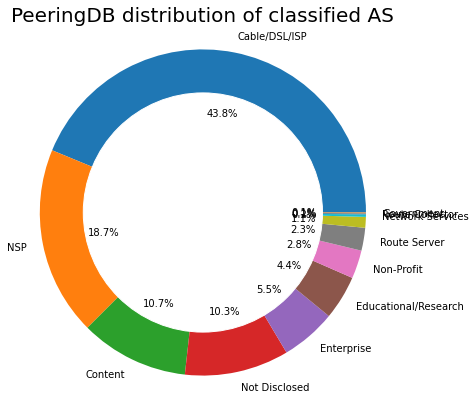

In [25]:
my_circle = plt.Circle( (0,0), 1.1, color='white')
plt.pie(net['info_type'].value_counts(), labels=['Cable/DSL/ISP', 'NSP', 'Content', 'Not Disclosed',
                                                 'Enterprise', 'Educational/Research', 'Non-Profit',
                                                 'Route Server', '', 'Network Services', 
                                                 'Route Collector', 'Government'],autopct='%1.1f%%', 
                                                  pctdistance=0.62, radius=1.5)
fig = plt.gcf()
fig.set_size_inches(5,5)

fig.gca().add_artist(my_circle)
plt.title("PeeringDB distribution of classified AS", pad=55, fontsize=20)
plt.show()

As we can see in the above cells, PerringDB provides a more interesting classification than CAIDA. <br>
We have 🔟 different classes here when we had only 3️⃣ with CAIDA.<br>

⚠️ We can see that some ASes weren't labelled. Indeed, 1195 of them have the label value of `Not Disclosed`. <br>We will have to handle this problem next ; for AS classification as well as for empty metadata.

In [26]:
#------------------------------------------------#
#   Function that creates the biapartite graph   #
#     with AS number as node feature and         #
#           weight as edge feature.              #
#      @param G : an empty graph                 #
#      @param filename : file to read            #
#      @return networkx graph : Graph as         #
#                            describe above      #
#------------------------------------------------#

def ajout_arete_bipartite_graph(G, filename):
    fichier = open(filename,"r")
    # Ajout des noeuds et arêtes 
    for ligne in fichier:
        tabligne = ligne.split(",")
        try:
            node1 = int(tabligne[0])
            node2 = int(tabligne[1])
            weight = float(tabligne[2])
            if node1 > 0:    
                G.add_edge(node1, node2, weight=weight)
        except ValueError:
            pass

In [27]:
FILE_SMALL = 'graph/0.9500_0.7500_pDB_petit.txt'

In [28]:
edgelist = open(FILE_SMALL, "r")
DiGraph_small = nx.parse_edgelist(edgelist, nodetype = int, data=(('weight',float),), create_using = nx.DiGraph, delimiter=",")

Text(0, -0.7, '13 out of 800 IXP')

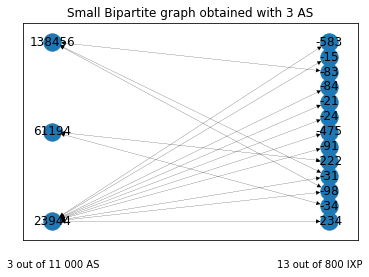

In [11]:
list_ixp = os.popen("cat %s | grep \"^-.*\" | cut -d \",\" -f 1 | sort | uniq | sort -h | tac" % FILE_SMALL).read()

nx.draw_networkx(
    DiGraph_small,
    pos=nx.drawing.bipartite_layout(DiGraph_small, [23944, 61194, 138456]),
    width=0.1)

plt.title("Small Bipartite graph obtained with 3 AS")
plt.text(-1.2, -0.7, "3 out of 11 000 AS")
plt.text(0, -0.7, "13 out of 800 IXP")

- Above is displayed a small example of a bipartite Graph obtained with PeeringDB. <br>
The real one (not displayable) contains much more ASes than IXP: 11 000 vs 800.

### Distribution of degree

In [29]:
#------------------------------------------------#
#   Function that creates the list which         #
#     contains the distribution of degree        #
#      @param G : a Networkx graph               #
#      @return List listenbvoisins : distribution#
#                                   of degree    #
#------------------------------------------------#
def listeNbVoisinsNoeudAS(G):
    nbNoeuds = G.number_of_nodes()
    b=list(G._node)
    listeDesVoisins = [b[i] for i in range(nbNoeuds) if b[i]>0]
    listenbvoisins = np.zeros(len(listeDesVoisins))
    for i in range(len(listeDesVoisins)) :
        listenbvoisins[i] = len(G[listeDesVoisins[i]])
    return listenbvoisins


lst = listeNbVoisinsNoeudAS(DiGraph)

In [30]:
liste_nb_noeud_k_voisin = np.zeros(int(max(lst)))
for i in range(len(lst)) :
    if lst[i]> 99 and lst[i]<200 :
        liste_nb_noeud_k_voisin[99]+=1
    elif lst[i]> 199 and lst[i]<300 :
        liste_nb_noeud_k_voisin[199]+=1
    elif lst[i]> 299 and lst[i]<400 :
        liste_nb_noeud_k_voisin[299]+=1
    elif lst[i]> 399 and lst[i]<500 :
        liste_nb_noeud_k_voisin[399]+=1
    elif lst[i]> 499 and lst[i]<600 :
        liste_nb_noeud_k_voisin[499]+=1
    elif lst[i]> 599 and lst[i]<700 :
        liste_nb_noeud_k_voisin[599]+=1
    elif lst[i]> 699 and lst[i]<800 :
        liste_nb_noeud_k_voisin[699]+=1
    elif lst[i]> 799 and lst[i]<900 :
        liste_nb_noeud_k_voisin[799]+=1
    elif lst[i]> 899 and lst[i]<1000 :
        liste_nb_noeud_k_voisin[899]+=1
    else :
        liste_nb_noeud_k_voisin[int(lst[i])-1]+=1

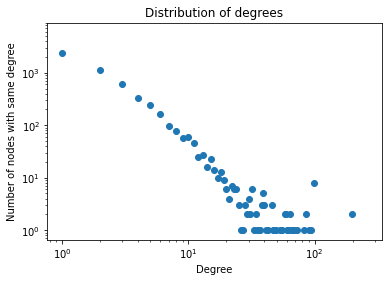

In [31]:
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title("Distribution of degrees")
plt.xlabel("Degree")
plt.ylabel("Number of nodes with same degree")
plt.scatter(arange(int(max(lst))),liste_nb_noeud_k_voisin)

⚠️ We used a log scale for a better vizualisation
- Here we see that the distribution of degree looks like a linear line. Most of the nodes have 1 or 2 neighboors but few of them have more than 100 neighboors. 

### Correlation between degree and port size

In [32]:
#-------------------------------------------------#
#  Function that creates 2 lists. The first one   #
# contains the weight and the second one contains #
#      the number of links  of each nodes         #
#      @param DiGraph : A directed graph          #
#      @return liste_poids, liste_nbliens : lists #
#                         as describe above       #
#-------------------------------------------------#

def poids_nbliens(DiGraph) :
    nbnoeud = DiGraph.number_of_nodes()
    liste_poids = np.zeros(nbnoeud)
    liste_nbliens = np.zeros(nbnoeud)

    liste_noeuds = list(DiGraph.nodes)
    for i in range(len(liste_noeuds)):
         if liste_noeuds[i]>0 :

            poids = 0
            liste_poids_voisin = list(DiGraph[liste_noeuds[i]].values())
            for j in range(len(liste_poids_voisin)):
                poids += liste_poids_voisin[j]["weight"]
            liste_poids[i]=poids
            liste_nbliens[i] = len(DiGraph[liste_noeuds[i]])
    return liste_poids, liste_nbliens


liste_poids, liste_nbliens = poids_nbliens(DiGraph)

- #### Now we can plot the weight of the nodes as a function of the degree 
<br> ⚠️ We use a log scale for a better vizualisation 

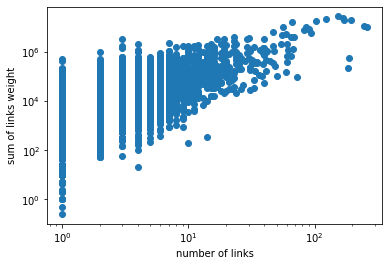

In [33]:
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title("")
plt.xlabel("number of links")
plt.ylabel("sum of links weight")
plt.scatter(liste_nbliens,liste_poids)

-  On this figure we see that some nodes have a few neighbors and a huge weight and vice-versa. <br> 
The two points off-center on the right represent DNS Servers which try to have a good Latency <br>
As there are at the right and not much on top, that means they have much more links than other, with no big amount of communication. <br><br>
We extracted **one AS strategy** that consists in having many neighbor with small port size for each.

## Extraction of relevant features

### Relevance of `policy_locations` metadata

In [34]:
net['policy_locations'].value_counts(normalize=True)*100

Not Required                87.332340
Preferred                   10.677654
Required - International     0.771456
                             0.622425
Required - US                0.315596
Required - EU                0.280529
Name: policy_locations, dtype: float64

We already can see that the distribution of `policy_locations` is already *not very interesting* because of it's distribution. <br>
Almost 90% of the values were concentrated in `Not Required` field.

- The first idea was to display the correlation between this data and the `port_capacity`. <br>For example, showing that `Required - US` have a high port capacity in order to create an ordinal class of the field `policy_locations`.
<br>
- The histogram figure below is only here to show that the metadata `policy_locations` was not relevant enought to keep it <br>

Text(0.5, 1.0, 'Port_capacity percentage')

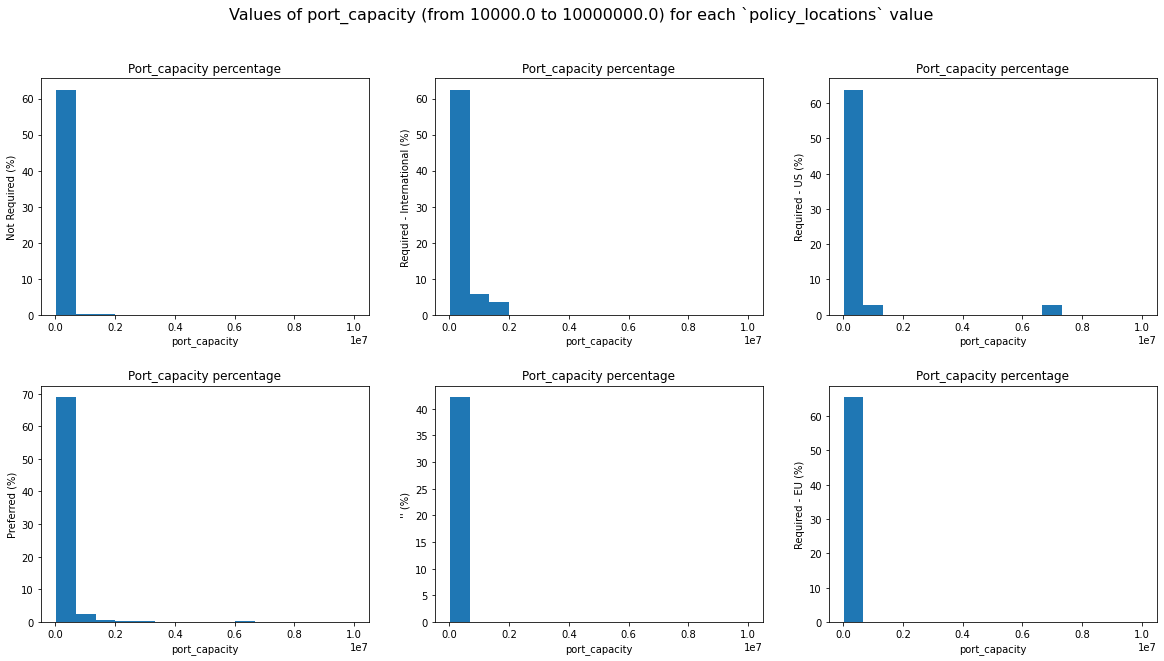

In [35]:
#-------------------------------------------------------------------------------------------------#
# Histograms showing the possible correlation between `policy_locations` and `port_capacity` data #
#-------------------------------------------------------------------------------------------------#


# Parameters values
nb_bins_hist=15
begin_port_value = 1e4
end_port_value   = 1e7
rang_hist=[begin_port_value, end_port_value]

# Configuration of the main figure
fig = plt.figure(figsize=(20,10))
fig.tight_layout(pad=3.0)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
fig.suptitle("Values of port_capacity (from %s to %s) for each `policy_locations` value" % (begin_port_value, end_port_value), fontsize=16)

data_not_required = net['port_capacity'] [net['policy_locations'] == 'Not Required']
data_preferred    = net['port_capacity'] [net['policy_locations'] == 'Preferred']
data_required_int = net['port_capacity'] [net['policy_locations'] == 'Required - International']
data_blank        = net['port_capacity'] [net['policy_locations'] == '']
data_required_US  = net['port_capacity'] [net['policy_locations'] == 'Required - US']
data_required_EU  = net['port_capacity'] [net['policy_locations'] == 'Required - EU']

## 6 histograms displayed

plt.subplot(2,3,1)
plt.hist(data_not_required, 
         bins=nb_bins_hist, range=rang_hist, weights=100*(np.ones(len(data_not_required)) /len(data_not_required)))
plt.xlabel("port_capacity")
plt.ylabel("Not Required (%)")
plt.title("Port_capacity percentage")

plt.subplot(2,3,4)
plt.hist(data_preferred,
         bins=nb_bins_hist, range=rang_hist, weights=100*(np.ones(len(data_preferred)) /len(data_preferred)))
plt.xlabel("port_capacity")
plt.ylabel("Preferred (%)")
plt.title("Port_capacity percentage")

plt.subplot(2,3,2)
plt.hist(data_required_int, 
         bins=nb_bins_hist, range=rang_hist, weights=100*(np.ones(len(data_required_int)) /len(data_required_int)))
plt.xlabel("port_capacity")
plt.ylabel("Required - International (%)")
plt.title("Port_capacity percentage")

plt.subplot(2,3,5)
plt.hist(data_blank, 
         bins=nb_bins_hist, range=rang_hist, weights=100*(np.ones(len(data_blank)) /len(data_blank)))
plt.xlabel("port_capacity")
plt.ylabel("'' (%)")
plt.title("Port_capacity percentage")

plt.subplot(2,3,3)
plt.hist(data_required_US, 
         bins=nb_bins_hist, range=rang_hist, weights=100*(np.ones(len(data_required_US)) /len(data_required_US)))
plt.xlabel("port_capacity")
plt.ylabel("Required - US (%)")
plt.title("Port_capacity percentage")

plt.subplot(2,3,6)
plt.hist(data_required_EU, 
         bins=nb_bins_hist, range=rang_hist, weights=100*(np.ones(len(data_required_EU)) /len(data_required_EU)))
plt.xlabel("port_capacity")
plt.ylabel("Required - EU (%)")
plt.title("Port_capacity percentage")


To print these 6 histograms, we extracted the port capacity of each `policy_locations` value.
We can see that The values are quite the same. 
There is no information added by `policy_locations` and its distribution is not selective or discriminant. <br>

**⇒ We won't use this metadata**

### Relevance of `info_traffic` metadata

In [36]:
net['info_traffic'].value_counts(normalize=True)*100

                27.281494
1-5Gbps         18.348383
5-10Gbps        11.072149
100-1000Mbps    10.072762
10-20Gbps        9.248707
20-50Gbps        7.889892
50-100Gbps       4.865434
100-200Gbps      2.743929
20-100Mbps       2.025072
1-5Tbps          1.560445
0-20Mbps         1.306215
500-1000Gbps     1.139651
300-500Gbps      1.078285
200-300Gbps      1.025686
10-20Tbps        0.149031
5-10Tbps         0.113965
20-50Tbps        0.043833
100+Tbps         0.026300
50-100Tbps       0.008767
Name: info_traffic, dtype: float64

👁 Despite the **27% of empty values**, the distribution is quite interesting. <br>
We have 18 fields that have on average a good contribution (more than 1%).

🔧 The only think to do is to assign the *empty 27%* values in the most relevant way.

In [37]:
dataset_info_traffic = pd.DataFrame()

# sort the fields to have a better printing with xlabels
info_traffic_sorted = ["nothing", "0-20M", "20-100M", "100-1000M", "1-5G", "5-10G", 
                       "10-20G", "20-50G", "50-100G", "100-200G", "200-300G",
                       "300-500G", "500-1000G", "1-5T", "5-10T", "10-20T", 
                       "20-50T", "50-100T", "100+T"]

In [38]:
# Extraction of each field
_nothing   = net['port_capacity'] [net['info_traffic'] == ""]
_0_20_M    = net['port_capacity'] [net['info_traffic'] == "0-20Mbps"]
_20_100M   = net['port_capacity'] [net['info_traffic'] == "20-100Mbps"]
_100_1000M = net['port_capacity'] [net['info_traffic'] == "100-1000Mbps"]
_1_5G      = net['port_capacity'] [net['info_traffic'] == "1-5Gbps"]
_5_10G     = net['port_capacity'] [net['info_traffic'] == "5-10Gbps"]
_10_20G    = net['port_capacity'] [net['info_traffic'] == "10-20Gbps"]
_20_50G    = net['port_capacity'] [net['info_traffic'] == "20-50Gbps"]
_50_100G   = net['port_capacity'] [net['info_traffic'] == "50-100Gbps"]
_100_200G  = net['port_capacity'] [net['info_traffic'] == "100-200Gbps"]
_200_300G  = net['port_capacity'] [net['info_traffic'] == "200-300Gbps"]
_300_500G  = net['port_capacity'] [net['info_traffic'] == "300-500Gbps"]
_500_1000G = net['port_capacity'] [net['info_traffic'] == "500-1000Gbps"]
_1_5T      = net['port_capacity'] [net['info_traffic'] == "1-5Tbps"]
_5_10T     = net['port_capacity'] [net['info_traffic'] == "5-10Tbps"]
_10_20T    = net['port_capacity'] [net['info_traffic'] == "10-20Tbps"]
_20_50T    = net['port_capacity'] [net['info_traffic'] == "20-50Tbps"]
_50_100T   = net['port_capacity'] [net['info_traffic'] == "50-100Tbps"]
_100_plusT = net['port_capacity'] [net['info_traffic'] == "100+Tbps"]

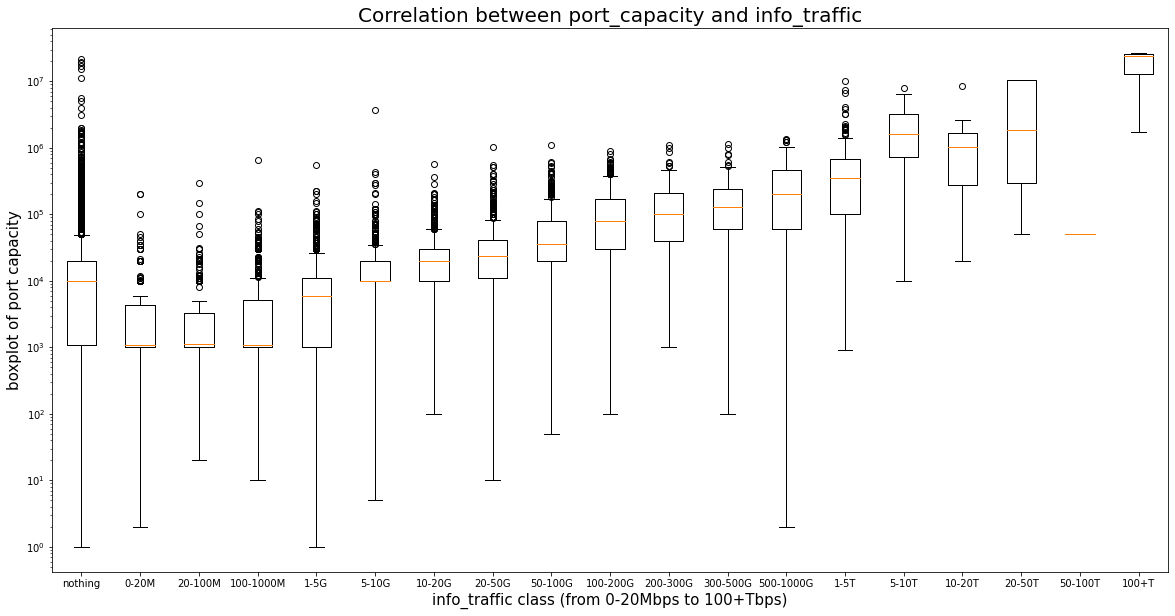

In [21]:
fig = plt.figure(figsize=(20,10))

plt.boxplot([_nothing, _0_20_M, _20_100M, _100_1000M, _1_5G, _5_10G, _10_20G, 
             _20_50G, _50_100G, _100_200G, _200_300G, _300_500G,
             _500_1000G, _1_5T, _5_10T, _10_20T, _20_50T, 
            _50_100T, _100_plusT])

plt.xticks(np.arange(1,20), info_traffic_sorted)
plt.xlabel("info_traffic class (from 0-20Mbps to 100+Tbps)", fontsize=15)
plt.ylabel("boxplot of port capacity", fontsize=15)
plt.title("Correlation between port_capacity and info_traffic", fontsize=20)

plt.yscale('log')

plt.show()

The box at the left is the `port_capacity` value of ASes with empty `info_traffic` data. <br>
We can see that the **median** is between the `5-10Gbps` and `10-20Gbps` values.
Therefore, we can label these empty AS between the values of the latter.

Indeed `info_traffic` will be transformed into an ordinal class with 19 possibles values growing from $1/19$, $2/19$ ... to $19/19$ = $1$ (**see next notebook**) 

### Final data kept

From the 34 metadata provided, 7 were finally kept, which are : <br>
`info_type` `info_ratio` `info_scope` `policy_general` `info_traffic` `port_capacity` `ix_count`. <br><br>
<center> Everything is summarized if the array below</center>

| Attribute name        | Meaning           | Possible values  |
| :-------------:       |:---------------:  | :--------------: |
| **info_type** (AS)    | classification de l'AS (NaN pour un IXP) | `Cable/DSL/ISP` `NSP` `Content` `Not Disclosed` `Enterprise` `Educational/Research` `Non-Profit` `Route Server` `""` `Network Services` `Route Collector` `Government`
| **info_ratio** (AS) | politique de communication de l'AS | `"" ` `Not Disclosed` `Heavy Outbound` <br><br>`Mostly Outbound` `Balanced` `Mostly Inbound` `Heavy Inbound` 
| **info_scope** (AS) | origine géographique de la mesure | `Not Disclosed` `Regional` `North America` <br>`Asia Pacific` `Europe` `South America` `Africa` `Australia` `Middle East` `Global` 
| **policy_general** |politique de traffic de l'AS | `""` `Open` `Selective` `Restrictive` `No`| 
| **info_traffic** | ordre de grandeur du traffic | `""` `0-20Mbps` `20-100Mbps` `100-1000Mbps`  `1-5Gbps` `5-10Gbps` `10-20Gbps` `20-50Gbps` `50-100Gbps` `100-200Gbps` `200-300Gbps` `300-500Gbps` `500-1000Gbps` `1-5Tbps` `5-10Tbps` `10-20Tbps` `20-50Tbps` `50-100Tbps` `100+Tbps`
| **port_capacity** (both) | bande passante d'un port | value in gigabyte : `1` to `26M8` for AS, `100` to `50M` for IXP
| **ix_count** (AS) | nombre d'IXP auquel l'AS se connecte | int from `1` to `328`
| **net_count** (IXP) | nombre d'AS auquel l'AS se connecte | int from `1` to `1309`

----------